# Day 5 Practical: Classic ML (k-NN, PCA & GMM)

**Objective:**
1.  Understand the **k-Nearest Neighbors (k-NN)** algorithm and its critical weaknesses.
2.  Use **Principal Component Analysis (PCA)** to overcome the "Curse of Dimensionality" for k-NN.
3.  Apply k-NN to a real medical feature dataset, including the vital **feature scaling** step.
4.  Use **Gaussian Mixture Models (GMM)** for an unsupervised medical segmentation task.


In [3]:
# --- Setup ---
# Run this cell to import all necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nilearn import datasets as nilearn_datasets
from nilearn import plotting
from sklearn.linear_model import LogisticRegression

c:\Users\luked\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Part 1: k-NN and the Curse of Dimensionality

**Concept:** k-NN works by finding the "closest" data points in a high-dimensional space. But what happens when that space has too many dimensions (like the 65,536 dimensions of a 256x256 image)?

**Hypothesis:** We will test if k-NN works *better* on *less* data.

**Dataset:** We'll use the `digits` dataset, a simple collection of 8x8 (64-dimensional) images of handwritten digits.


In [4]:
# 1. Load the digits dataset
digits = datasets.load_digits()
X = digits.data
y = digits.target

print(f"Data shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")

# X is (1797, 64) -> 1797 images, each with 64 features (pixels)
# y is (1797,) -> 1797 labels (the numbers 0-9)

# 2. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Data shape (X): (1797, 64)
Target shape (y): (1797,)


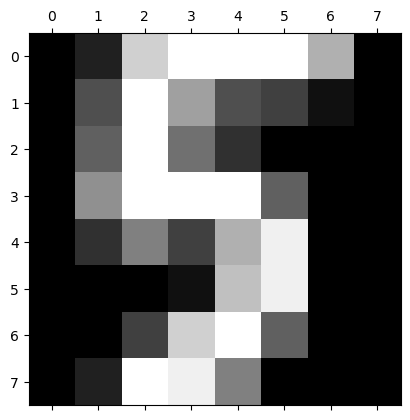

In [4]:
plt.matshow(digits.images[32], cmap="gray")
plt.show()

**Task 1: k-NN on Raw, High-Dimensional Data**

1.  Create and train a `KNeighborsClassifier` (use `n_neighbors=5`) on the **raw** `X_train` data.
2.  Make predictions on `X_test`.
3.  Calculate and print the `accuracy_score`.


In [5]:
# 1. Create and train the k-NN classifier
knn_raw = KNeighborsClassifier(n_neighbors=5)
knn_raw.fit(X_train, y_train)

# 2. Make predictions
y_pred_raw = knn_raw.predict(X_test)

# 3. Calculate and print accuracy
acc_raw = accuracy_score(y_test, y_pred_raw)
print(f"Accuracy on 64-dim data: {acc_raw:.4f}")

Accuracy on 64-dim data: 0.9870


**Task 2: k-NN on Low-Dimensional, PCA-Transformed Data**

Now, let's see if we can *improve* performance by first reducing the 64 dimensions.

1.  Create a `PCA` object (use `n_components=10`) and `fit_transform` it on `X_train`.
2.  **Important:** `transform` (do not *re-fit*) the `X_test` data using the *same* PCA model.
3.  Create and train a new `KNeighborsClassifier` on the **PCA-transformed** training data.
4.  Make predictions on the **PCA-transformed** test data.
5.  Calculate and print the accuracy.


In [6]:
# 1. Create and fit PCA on the training data
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)

# 2. Transform the test data (do NOT re-fit)
X_test_pca = pca.transform(X_test)

print(f"Original shape: {X_train.shape}")
print(f"Reduced shape: {X_train_pca.shape}")

# 3. Create and train k-NN on the PCA-reduced data
knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(X_train_pca, y_train)

# 4. Make predictions on PCA-reduced test data
y_pred_pca = knn_pca.predict(X_test_pca)

# 5. Calculate and print accuracy
acc_pca = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy on 10-dim data: {acc_pca:.4f}")


Original shape: (1257, 64)
Reduced shape: (1257, 10)
Accuracy on 10-dim data: 0.9704


 **Analysis**

We notice that the accuracy for KNN on the raw data is 98.7%, while the accuracy for KNN on the PCA-reduced data is only 97.04%. This 1.7 point drop is a minor tradeoff against reduced data dimensionality. Indeed, we conserve 98.3% of the original accuracy (97.0 / 98.7) while using only 15.6% (10 / 64) of the data. 

This means that most of the information which allows to differentiate between points can be captured in **only 10 dimensions** using PCA. 

**Task 3: Quantifying the Curse of Dimensionality**

Let's prove that distances become less meaningful in high dimensions.

**Task:** Write a loop that iterates over different numbers of PCA components (e.g., `d` = 2, 5, 10, 20, 30, 64). For each `d`, transform the *test data* `X_test`. Then, for the *first test point* (`X_test_transformed[0]`), find its nearest neighbor and its farthest neighbor in the *rest of the test set*. Calculate the ratio: `dist_farthest / dist_nearest`.

Plot this ratio as `d` increases. You should see the ratio shrink towards 1, meaning the farthest point is almost as "close" as the nearest point.


Dim= 2 | Nearest=1.28 | Farthest=34.21 | Ratio=26.75
Dim= 3 | Nearest=2.02 | Farthest=50.41 | Ratio=24.99
Dim= 4 | Nearest=3.67 | Farthest=50.81 | Ratio=13.84
Dim= 5 | Nearest=5.09 | Farthest=58.66 | Ratio=11.52
Dim= 6 | Nearest=6.07 | Farthest=60.35 | Ratio=9.94
Dim= 7 | Nearest=6.17 | Farthest=60.91 | Ratio=9.88
Dim= 8 | Nearest=6.21 | Farthest=60.93 | Ratio=9.81
Dim= 9 | Nearest=6.21 | Farthest=61.08 | Ratio=9.83
Dim=10 | Nearest=8.79 | Farthest=61.35 | Ratio=6.98
Dim=20 | Nearest=9.36 | Farthest=64.97 | Ratio=6.94
Dim=30 | Nearest=9.70 | Farthest=65.51 | Ratio=6.75
Dim=40 | Nearest=10.07 | Farthest=66.07 | Ratio=6.56
Dim=50 | Nearest=10.68 | Farthest=66.26 | Ratio=6.21
Dim=64 | Nearest=10.68 | Farthest=66.26 | Ratio=6.21


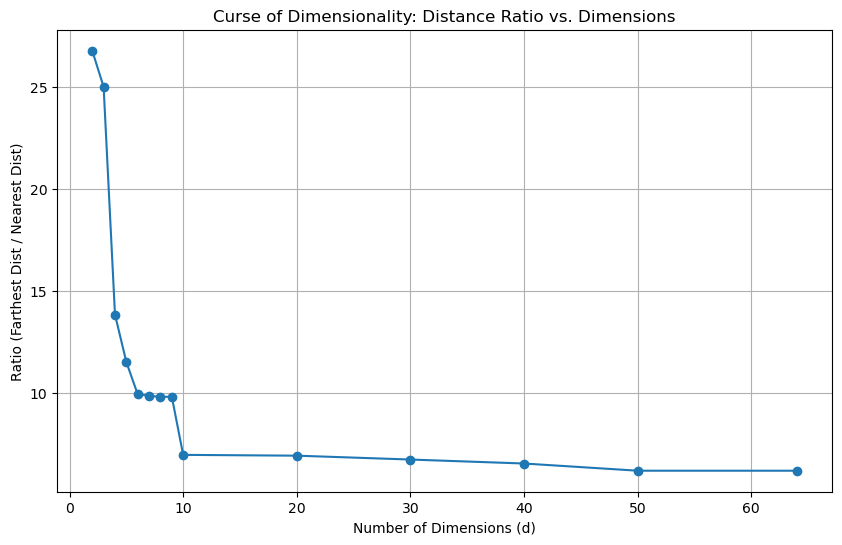

In [7]:
from scipy.spatial.distance import cdist

dims = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 64]
dist_ratios = []
query_point_idx = 0

for d in dims:
    # 1. Create a PCA model with 'd' components and transform X_test
    if d == 64:
        # Special case: no PCA needed, just use the raw data
        X_test_transformed = X_test
    else:
        pca_d = PCA(n_components=d)
        X_test_transformed = pca_d.fit_transform(X_test) # Fit on test data for this demo
    
    # 2. Get the query point (the first point)
    query_point = X_test_transformed[query_point_idx:query_point_idx+1]
    # Get the rest of the points
    other_points = np.delete(X_test_transformed, query_point_idx, axis=0)
    
    # 3. Calculate all distances from the query point to the other points
    # 'cdist' is a fast way to compute distances
    distances = cdist(query_point, other_points, metric='euclidean').ravel()
    
    # 4. Find the min and max distances
    dist_nearest = np.min(distances)
    dist_farthest = np.max(distances)
    
    # 5. Calculate the ratio and append it
    ratio = dist_farthest / dist_nearest
    dist_ratios.append(ratio)
    
    print(f"Dim={d:2} | Nearest={dist_nearest:.2f} | Farthest={dist_farthest:.2f} | Ratio={ratio:.2f}")

# 6. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(dims, dist_ratios, marker='o')
plt.title('Curse of Dimensionality: Distance Ratio vs. Dimensions')
plt.xlabel('Number of Dimensions (d)')
plt.ylabel('Ratio (Farthest Dist / Nearest Dist)')
plt.grid(True)
plt.show()

**Task 4: Visualisation of the principal plan**

Let's map all the datapoints against the first two principal directions (PC1, PC2) of the PCA. 

Forme originale des données : (1797, 64)
Nouvelle forme des données : (1797, 2)


C:\Users\luked\AppData\Local\Temp\ipykernel_37140\4136355223.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('jet', 10),


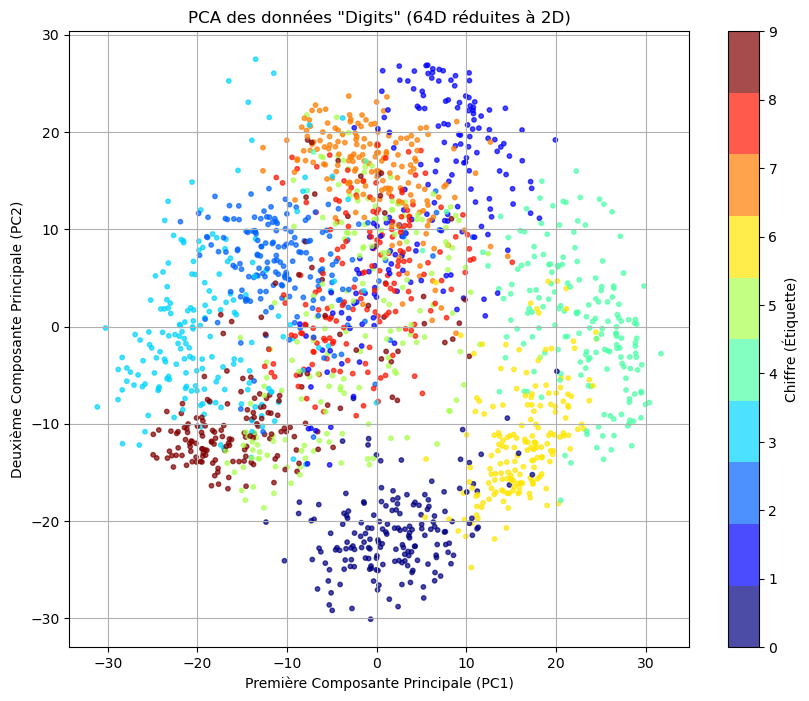

Variance expliquée par PC1 : 14.89%
Variance expliquée par PC2 : 13.62%
Variance totale expliquée par les 2 composantes : 28.51%


In [ ]:
# Nous utilisons les données complètes X et y pour la visualisation
X = digits.data
y = digits.target

# 1. Créer un nouveau modèle PCA pour 2 composantes
pca_2d = PCA(n_components=2)

# 2. Appliquer la PCA aux données (de 64D à 2D)
X_pca_2d = pca_2d.fit_transform(X)

print(f"Forme originale des données : {X.shape}")
print(f"Nouvelle forme des données : {X_pca_2d.shape}")

# --- Création du graphique ---
plt.figure(figsize=(10, 8))

# 3. Créer un nuage de points
# X-axis: Première composante principale (PC1)
# Y-axis: Deuxième composante principale (PC2)
# c=y : Attribuer la couleur en fonction de l'étiquette du chiffre (y)
# cmap=... : Utiliser une palette de 10 couleurs distinctes
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, 
                      cmap=plt.cm.get_cmap('jet', 10), 
                      alpha=0.7, s=10)

plt.title('PCA des données "Digits" (64D réduites à 2D)')
plt.xlabel('Première Composante Principale (PC1)')
plt.ylabel('Deuxième Composante Principale (PC2)')

# 4. Ajouter une barre de couleur pour servir de légende
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label('Chiffre (Étiquette)')

plt.grid(True)
plt.show()

# 5. Vérifier la variance expliquée
print(f"Variance expliquée par PC1 : {pca_2d.explained_variance_ratio_[0]:.2%}")
print(f"Variance expliquée par PC2 : {pca_2d.explained_variance_ratio_[1]:.2%}")
print(f"Variance totale expliquée par les 2 composantes : {np.sum(pca_2d.explained_variance_ratio_):.2%}")

## Part 2: k-NN for Medical Feature Classification

**Concept:** We've established that k-NN works best on low-dimensional *feature vectors*. Here, we'll use a famous dataset of features extracted from breast cancer histology images.

**Dataset:** `load_breast_cancer`. The features are "mean radius", "mean texture", "mean perimeter", etc.

**Challenge:** k-NN is distance-based. A feature that ranges from 0-1000 (e.g., "area") will completely dominate a feature that ranges from 0-1 (e.g., "symmetry"). We **must** scale our data.

In [11]:
# 1. Load the dataset
cancer = datasets.load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target

print(f"Cancer data shape: {X_cancer.shape}") # 569 patients, 30 features
print(f"First 5 values of feature 0: {X_cancer[:5, 0]}")
print(f"First 5 values of feature 5: {X_cancer[:5, 5]}")
print(f"What is y_cancer[0]: {y_cancer[0]}")
# Notice the massive difference in scale!

# 2. Split the data
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cancer, y_cancer, test_size=0.3, random_state=42)

Cancer data shape: (569, 30)
First 5 values of feature 0: [17.99 20.57 19.69 11.42 20.29]
First 5 values of feature 5: [0.2776  0.07864 0.1599  0.2839  0.1328 ]
What is y_cancer[0]: 0


**Task 5: The Importance of Feature Scaling**

1.  Create a `StandardScaler` object.
2.  `fit_transform` the scaler on `X_train_c`.
3.  `transform` the `X_test_c` data using the *same* scaler.
4.  Train a `KNeighborsClassifier` on the **scaled** training data.
5.  Evaluate its accuracy on the **scaled** test data.

In [12]:
print("\n--- k-NN on Scaled Medical Features ---")

# 1. Create a StandardScaler
scaler = StandardScaler()

# 2. Fit on training data and transform it
X_train_scaled = scaler.fit_transform(X_train_c)

# 3. Transform the test data (do NOT re-fit)
X_test_scaled = scaler.transform(X_test_c)

print(f"Original mean of feature 0: {X_train_c[:, 0].mean():.2f}")
print(f"Scaled mean of feature 0: {X_train_scaled[:, 0].mean():.2f}") # Should be ~0
print(f"Scaled std dev of feature 0: {X_train_scaled[:, 0].std():.2f}") # Should be ~1

# 4. Train k-NN on the SCALED data
knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_scaled, y_train_c)

# 5. Evaluate on the SCALED test data
y_pred_scaled = knn_scaled.predict(X_test_scaled)
acc_scaled = accuracy_score(y_test_c, y_pred_scaled)
print(f"Accuracy with scaled features: {acc_scaled:.4f}")

# 6. Train & evaluate on the unscaled test data
knn_unscaled = KNeighborsClassifier(n_neighbors=5)
knn_unscaled.fit(X_train_c, y_train_c)
y_pred_unscaled = knn_unscaled.predict(X_test_c)
acc_unscaled = accuracy_score(y_test_c, y_pred_unscaled)
print(f"Accuracy with unscaled features: {acc_unscaled:.4f}")


--- k-NN on Scaled Medical Features ---
Original mean of feature 0: 14.18
Scaled mean of feature 0: -0.00
Scaled std dev of feature 0: 1.00
Accuracy with scaled features: 0.9591
Accuracy with unscaled features: 0.9591


**Analysis**: We find no difference in accuracy between the kNN with scaled features and kNN with the unscaled features. This is most likely due to the fact that a very low number of features (1) carries the majority of explained variance. We can confirm this by performing a PCA and an explained variance analysis.  

In [13]:
# 1. Create and fit PCA on the training data
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_c)

# 2. Transform the test data (do NOT re-fit)
X_test_pca = pca.transform(X_test_c)

print(f"Original shape: {X_train_c.shape}")
print(f"Reduced shape: {X_train_pca.shape}")

# 3. Create and train k-NN on the PCA-reduced data
knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(X_train_pca, y_train_c)

# 4. Make predictions on PCA-reduced test data
y_pred_pca = knn_pca.predict(X_test_pca)

# 5. Calculate and print accuracy
acc_pca = accuracy_score(y_test_c, y_pred_pca)
print(f"Accuracy on 10-dim data: {acc_pca:.4f}")

Original shape: (398, 30)
Reduced shape: (398, 10)
Accuracy on 10-dim data: 0.9591


In [62]:
print(pca.explained_variance_ratio_)

[9.81351172e-01 1.65201603e-02 1.91058893e-03 1.25398750e-04
 8.11330525e-05 6.08082346e-06 4.02179396e-06 8.23002131e-07
 3.71230177e-07 1.54414083e-07]


**Analysis**: The first PC has 98.1% of the explained variance. One feature is overtaking all others, and is becoming a key discriminator. 

**Task 6: Find the Optimal `k`**

`k=5` was a guess. Write a `for` loop that iterates `k` from 1 to 20. In the loop, train a k-NN model and save its accuracy on the **test set**. Plot the results.


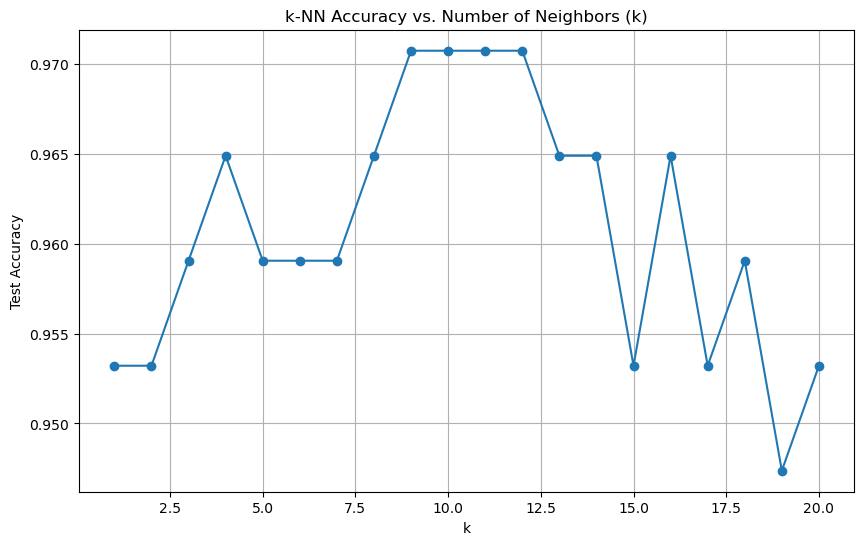

In [14]:
k_values = range(1, 21)
test_accuracies = []

for k in k_values:
    # 1. Create and train a new k-NN classifier with the current 'k'
    #    (Use the scaled training data)
    knn_loop = KNeighborsClassifier(n_neighbors=k)
    knn_loop.fit(X_train_scaled, y_train_c)
    
    # 2. Get predictions and accuracy on the *scaled test data*
    acc_k = knn_loop.score(X_test_scaled, y_test_c)
    
    # 3. Append the accuracy to the list
    test_accuracies.append(acc_k)

# 3. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, test_accuracies, marker='o')
plt.title('k-NN Accuracy vs. Number of Neighbors (k)')
plt.xlabel('k')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()


**Analysis**: The optimal k-value range lies between 9 and 12 included. 

 **Task 7: Comparing k-NN with Logistic Regression**

 k-NN is a non-parametric, distance-based model. Logistic Regression is a parametric, linear model.

 **Task:** Train a `LogisticRegression` model on the **same scaled data** (`X_train_scaled`, `y_train_c`). Compare its test accuracy to the *best* k-NN accuracy you found in your loop. Which one performs better on this dataset?


In [17]:
# 1. Create and train a LogisticRegression model
# (It's good practice to set max_iter to a higher value)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train_c)

# 2. Get predictions and accuracy on the *scaled test data*
y_pred_log_reg = log_reg.predict(X_test_scaled)
acc_log_reg = accuracy_score(y_test_c, y_pred_log_reg)

print(f"Best k-NN Accuracy: {max(test_accuracies):.4f}")
print(f"Logistic Regression Accuracy: {acc_log_reg:.4f}")

Best k-NN Accuracy: 0.9708
Logistic Regression Accuracy: 0.9825


**Analysis**: The LogReg yields a higher accuracy for this dataset than any k-NN method. 

## Part 3: Gaussian Mixture Models (GMM) for Unsupervised Segmentation

**Concept:** This is a totally different task. k-NN was *supervised* (it used labels). GMM is *unsupervised* (it finds hidden clusters).

**Relevance:** This is a classic method for simple medical image segmentation. We will model the pixel intensities of a brain MRI as a "mixture" of different distributions (e.g., one for air/skull, one for gray matter, one for white matter).

**Dataset:** A single, standard T1-weighted brain MRI slice from `nilearn`.

Original image shape: (95, 99)
Pixel vector shape: (9405, 1)


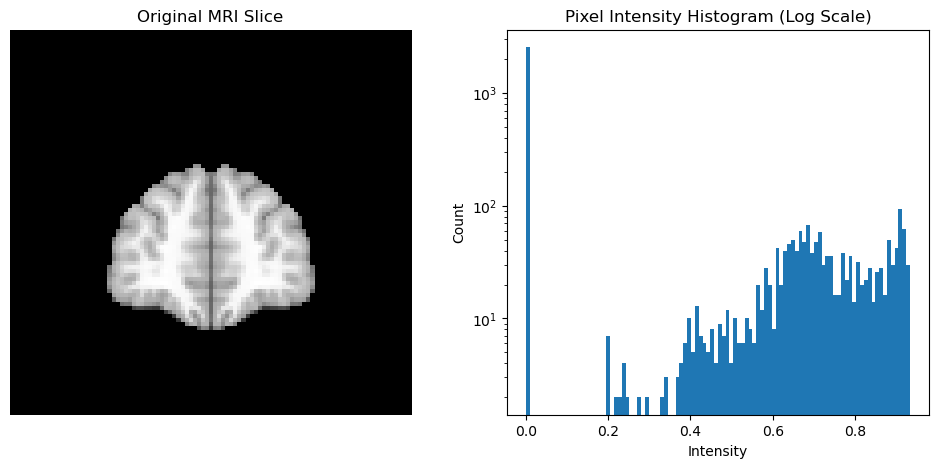

In [5]:
# 1. Load the data
# This fetches a standard MNI152 T1-weighted brain MRI
mri_data = nilearn_datasets.load_mni152_template(resolution=2)
mri = mri_data.get_fdata()

# 2. We'll select a single 2D slice from the middle of the brain (coronal view)
# Slicing is [x, y, z]
img = mri[:, 92, :]
img = np.rot90(img) # Rotate for better viewing

print(f"Original image shape: {img.shape}")

# 3. Flatten the 2D image into a 1D vector of pixels
# This is our data X. We must reshape it to (n_samples, n_features)
X_pixels = img.reshape(-1, 1)
print(f"Pixel vector shape: {X_pixels.shape}")


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original MRI Slice')
plt.axis('off')

# Plot the histogram of pixel intensities
# We only plot non-zero pixels for a cleaner histogram
plt.subplot(1, 2, 2)
plt.hist(X_pixels[X_pixels > 0], bins=100, log=True)
plt.title('Pixel Intensity Histogram (Log Scale)')
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.show()


**Task 8: Fit a GMM to the Pixel Intensities**

1.  Create a `GaussianMixture` model. Set `n_components=4`. (We'll guess this corresponds to 1:Air, 2:CSF, 3:Gray Matter, 4:White Matter).
2.  `fit()` the GMM model to the `X_pixels` data.
3.  Use the *trained* model to `.predict()` the cluster label for each pixel in `X_pixels`.
4.  `reshape()` the resulting 1D array of labels back into the original 2D image shape (`img.shape`).
5.  Plot the original and segmented images.



--- GMM Segmentation ---
GMM fitting complete.
Segmented image shape: (95, 99)


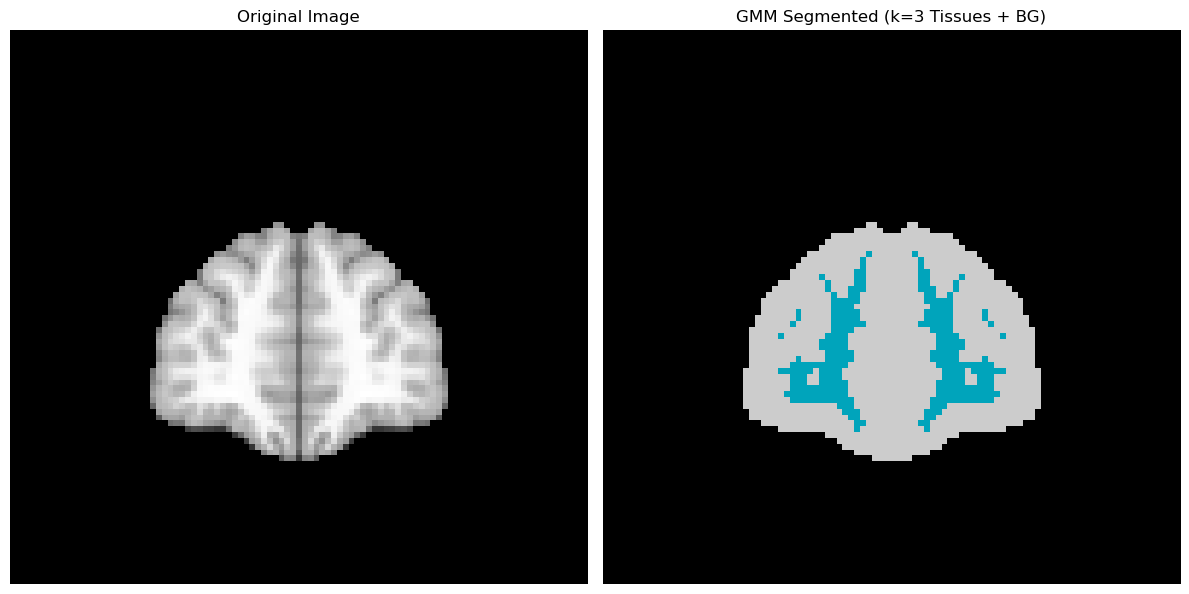

In [11]:
print("\n--- GMM Segmentation ---")

# We'll filter out the pure-black background pixels first for a cleaner fit
X_fit = X_pixels[X_pixels > 0].reshape(-1, 1)

# 1. Create and fit the GMM
# Set random_state for reproducible results
# We will fit on 3 components: CSF, Gray, White
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_fit)

print("GMM fitting complete.")

# 2. Predict the cluster for *all* pixels (including background)
labels = gmm.predict(X_pixels)

# 3. The background (intensity 0) will be one cluster. 
# We can set it to 0 and shift other labels up.
bg_label = labels[0] # Get the label assigned to the first (background) pixel
labels_shifted = np.where(labels == bg_label, 0, labels + 1)

# 4. Reshape the labels back to the original image shape
segmented_img = labels_shifted.reshape(img.shape)

print(f"Segmented image shape: {segmented_img.shape}")

# 5. Plot the results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# We use nipy_spectral colormap for better visualization
axes[1].imshow(segmented_img, cmap='nipy_spectral')
axes[1].set_title('GMM Segmented (k=3 Tissues + BG)')
axes[1].axis('off')

plt.tight_layout()
plt.show()


**Analysis:**

1.  **How did we obtain this segmentation?** 

The only property of the MRI used to create the clusters was pixel intensity. The assumption is that the histogram shown above with the intensity counts results from the superposition of three Gaussian distributions, with three different parameters $\mu$ and $\sigma$. 

2.  **Why did GMM mostly succeed in separating different tissue types?** 

Because the property used (pixel intensity) matches the reality of a T1 weighted MRI. 

Indeed, the pixel intensity is correlated with T1 relaxation times, which physically represents the time it takes for the longitudinal magnetization ($M_z$) to return to 63% of its original value, after the end of the RF pulse. 

Different tissues have different T1 times: CSF is dark (low intensity), gray matter is in the middle, and white matter is bright (high intensity).

3.  **What are the major limitations of this segmentation method?** 

It ignores spatial context because it analyzes each pixel individually, not within its neighborhood. This leads to misclassification of certain pixels. A human or a CNN both would use spatial context. For instance, CNN use spatial filters to analyze a pixel's entire neighborhood before making a decision.

**Task 9: How many clusters? (AIC/BIC)**

We guessed `k=3` tissues. But how can we *quantify* the best number of components?

The `GaussianMixture` object has built-in methods: `.aic(X_fit)` and `.bic(X_fit)`. These are scores that measure model quality while penalizing for adding more components (more complexity).

**Task:** Write a loop for `k` in `range(2, 9)`. For each `k`, fit a new GMM (on `X_fit`) and store its AIC and BIC scores. Plot both scores vs. `k`. The "elbow" or minimum score is generally preferred.


Loop complete.


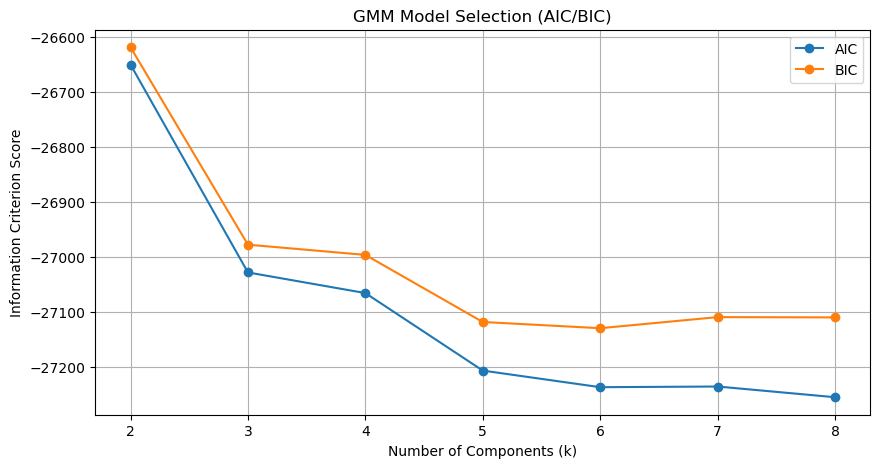

In [ ]:
AIC_scores=[]
BIC_scores=[]
k_to_test = range(2, 9)

for k in range(2,9):
    gmm_k = GaussianMixture(n_components=k, random_state=42)
    gmm_k.fit(X_fit)
    AIC_scores.append(gmm_k.aic(X_fit))
    BIC_scores.append(gmm_k.bic(X_fit))

print("Loop complete.")

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(k_to_test, AIC_scores, label='AIC', marker='o')
plt.plot(k_to_test, BIC_scores, label='BIC', marker='o')
plt.title('GMM Model Selection (AIC/BIC)')
plt.xlabel('Number of Components (k)')
plt.ylabel('Information Criterion Score')
plt.legend()
plt.grid(True)
plt.show()

According to the Elbow Rule applied to BIC and AIC, k = 5 would be a more appropriate choice. 